## Load the images and labels from local files

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2

# Load the data from the json file
images = []
labels = []

with open('data/labels.json', 'r') as labels_file:
    for line in labels_file:
        data = json.loads(line)
        images.append(data['image'])
        labels.append(data['label'])


## Analyze the data

Steering angle statistics
Mean:  0.008243302713475637
Standard deviation:  0.04808864083978031
Max:  0.5819758176803589
Min:  -0.10519091784954071


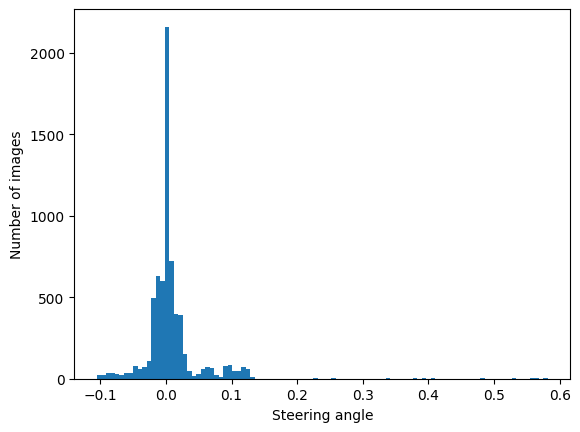

In [134]:
# Steering angle statistics
print('Steering angle statistics')
print('Mean: ', np.mean(labels))
print('Standard deviation: ', np.std(labels))
print('Max: ', np.max(labels))
print('Min: ', np.min(labels))

# Steering angle histogram
plt.hist(labels, bins=100)
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.show()


## Preprocess the data

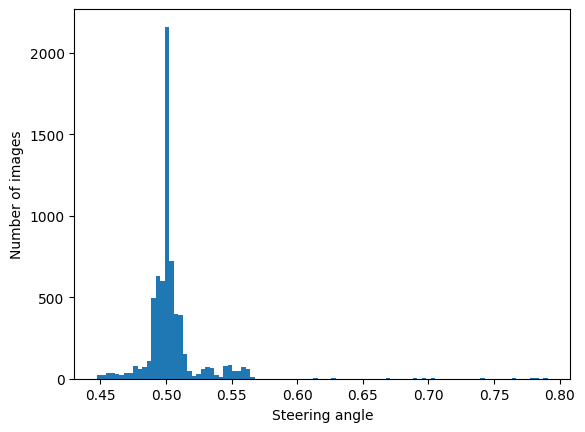

In [144]:
# Center steering angles around 0.5
labels_norm = (np.array(labels) + 1)/2

# Plot histogram of steering angles
plt.hist(labels_norm, bins=100)
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.show()

Number of samples before filtering: 6861
Number of samples after filtering: 1069


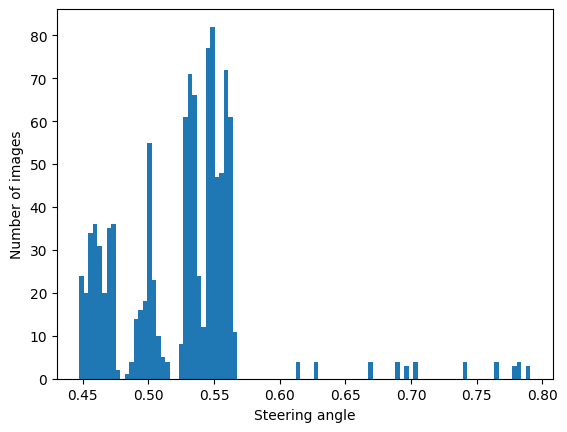

In [136]:
# Filter the data to avoid overfitting to straight direction
filtered_images = []
filtered_labels = []

for image, label in zip(images, labels_norm):
    if abs(label - 0.5) > 0.025:
        filtered_images.append(image)
        filtered_labels.append(label)
    elif np.random.rand() < 0.03:
        filtered_images.append(image)
        filtered_labels.append(label)

print(f'Number of samples before filtering: {len(images)}')
print(f'Number of samples after filtering: {len(filtered_images)}')

# Plot histogram of steering angles
plt.hist(filtered_labels, bins=100)
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.show()


Number of samples before filtering: 1069
Number of samples after filtering: 1028


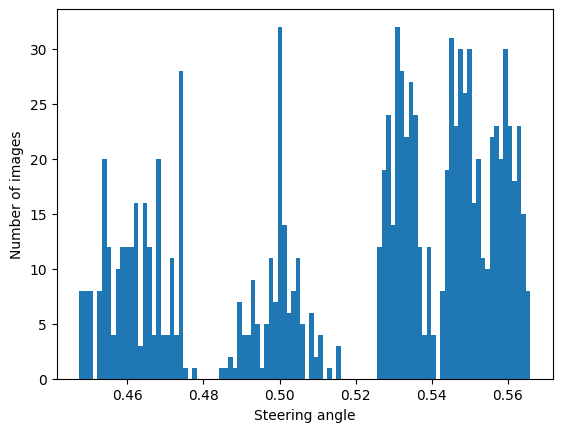

In [137]:
# Filter data with labels bigger than 0.6
filt_images = []
filt_labels = []

for image, label in zip(filtered_images, filtered_labels):
    if label < 0.6:
        filt_images.append(image)
        filt_labels.append(label)

print(f'Number of samples before filtering: {len(filtered_labels)}')
print(f'Number of samples after filtering: {len(filt_labels)}')

# Plot histogram of steering angles
plt.hist(filt_labels, bins=100)
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.show()

## Create dataset and dataloaders for training and validation

In [152]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms, utils

class CarlaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = cv2.imread('data/images/' + self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


torch.Size([3, 256, 256]) 0.5004415237344801


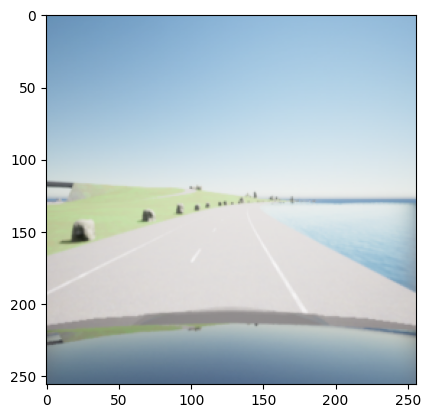

torch.Size([3, 256, 256]) 0.5004408151726238


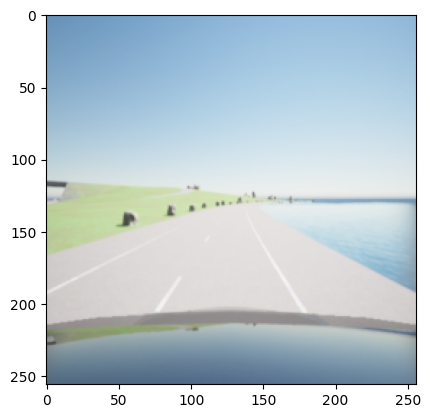

torch.Size([3, 256, 256]) 0.49947280052583665


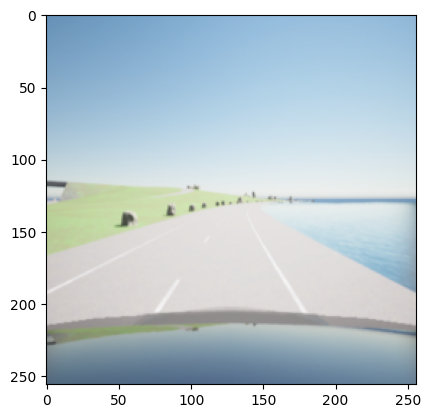

In [189]:
# Select the data
selected_images = filt_images
selected_labels = filt_labels

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
dataset = CarlaDataset(selected_images, selected_labels, transform=transform)

# Show some examples
for i in range(3):
    image, label = dataset[i]
    print(image.shape, label)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

In [165]:
# Create the training and validation dataloaders
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)




In [166]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import datetime



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train(model, train_loader, validation_loader, epochs, criterion, optimizer):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    best_val_loss = np.inf

    # Create a weight path using the day, hour, minute and second
    now = datetime.datetime.now()
    pth_path = f'model_{now.day}_{now.hour}_{now.minute}_{now.second}.pth'

    for epoch in range(epochs):
        model.train()
        train_loss = []
        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')  
        for data, target in pbar:
            data = data.permute(0,3,1,2).float().to(device)
            target = target.float().to(device)
            optimizer.zero_grad()
            outputs = model(data)
            #print(outputs)
            loss = criterion(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            pbar.set_postfix({'train_loss': np.mean(train_loss)})  
        train_loss = np.mean(train_loss)
        
        model.eval()
        validation_loss = []
        pbar = tqdm(validation_loader, desc=f'Validation Epoch {epoch}') 
        for data, target in pbar:
            data = data.permute(0,3,1,2).float().to(device)
            target = target.float().to(device)
            outputs = model(data)
            loss = criterion(outputs, target.unsqueeze(1))
            validation_loss.append(loss.item())
            pbar.set_postfix({'validation_loss': np.mean(validation_loss)})
        validation_loss = np.mean(validation_loss)

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

            print('Saving the model')
            torch.save(model.state_dict(), pth_path)
        
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        
        print(f'Epoch {epoch}, train loss: {train_loss}, validation loss: {validation_loss}')
        
    return train_losses, validation_losses

In [167]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__ (self, image_w, image_h):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        
        self.fc1 = nn.Linear(64*38*73, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.out = nn.Linear(10, 1)
        
        self.dropout = nn.Dropout(p = 0.2) # set to 0 for now

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)

        return x

In [168]:
import torch.nn.functional as F

class Simpler_Net(nn.Module):
    def __init__ (self, image_w, image_h):
        super(Simpler_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        
        self.fc1 = nn.Linear(36*88*158, 50)
        self.out = nn.Linear(50, 1)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x) 
        
        return x

In [169]:

# Create the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

image_w = 640
image_h = 360
model = Net(image_w, image_h).to(device)
print(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 20
train_losses, validation_losses = train(model, train_loader, validation_loader, epochs=epochs, criterion=criterion, optimizer=optimizer)



cuda:0
Net(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=177536, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Validation Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s, validation_loss=0.0136]


Saving the model
Epoch 0, train loss: 10.604168491644991, validation loss: 0.013620885754270213


Validation Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s, validation_loss=0.011]  


Saving the model
Epoch 1, train loss: 0.06189569568744412, validation loss: 0.011042378776307617


Validation Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s, validation_loss=0.0147]


Epoch 2, train loss: 0.04640511223287494, validation loss: 0.01473793520459107


Validation Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s, validation_loss=0.0171]


Epoch 3, train loss: 0.04832816475795375, validation loss: 0.017072358301707675


Validation Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.13it/s, validation_loss=0.00683]


Saving the model
Epoch 4, train loss: 0.03438708475894398, validation loss: 0.00683021971157619


Validation Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s, validation_loss=0.0102] 


Epoch 5, train loss: 0.037353079972995654, validation loss: 0.010194559515054737


Validation Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s, validation_loss=0.0185]


Epoch 6, train loss: 0.029179770154533564, validation loss: 0.01845565079046147


Validation Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s, validation_loss=0.00357]


Saving the model
Epoch 7, train loss: 0.026129364277477616, validation loss: 0.0035708106255957057


Validation Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s, validation_loss=0.0148]


Epoch 8, train loss: 0.027047052013653296, validation loss: 0.01481217345488923


Validation Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, validation_loss=0.012]  


Epoch 9, train loss: 0.021385266928485146, validation loss: 0.012003751604684762


Validation Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s, validation_loss=0.00718]


Epoch 10, train loss: 0.023138885489768453, validation loss: 0.007176089300108808


Validation Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s, validation_loss=0.0111] 


Epoch 11, train loss: 0.021004156795916735, validation loss: 0.01106069509738258


Validation Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s, validation_loss=0.00762]


Epoch 12, train loss: 0.02107486204692611, validation loss: 0.0076162344110863546


Validation Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s, validation_loss=0.00416]


Epoch 13, train loss: 0.020665072111619845, validation loss: 0.004157171343519751


Validation Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s, validation_loss=0.0123]


Epoch 14, train loss: 0.020887008764677577, validation loss: 0.01225232013634273


Validation Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s, validation_loss=0.00556]


Epoch 15, train loss: 0.01844109781086445, validation loss: 0.005555685543056045


Validation Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s, validation_loss=0.0082] 


Epoch 16, train loss: 0.014616481407924934, validation loss: 0.00820240844041109


Validation Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s, validation_loss=0.00612]


Epoch 17, train loss: 0.01724500388458923, validation loss: 0.006119081484419959


Validation Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s, validation_loss=0.00404]


Epoch 18, train loss: 0.01746745386885272, validation loss: 0.004039893849819366


Validation Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s, validation_loss=0.00854]

Epoch 19, train loss: 0.015923749000110007, validation loss: 0.008544713192220246


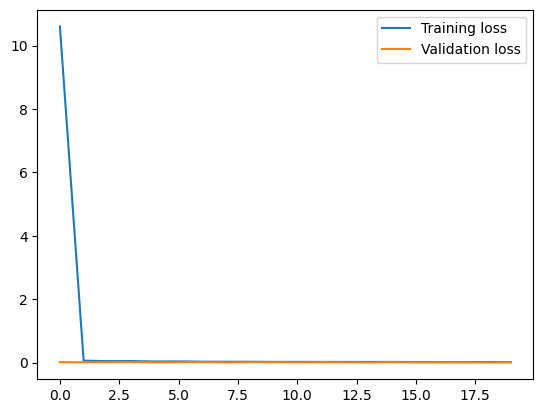

In [170]:
# Print history of losses
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()
plt.show()


## Run prediction on the validation set

Testing: 100%|██████████| 27/27 [00:05<00:00,  4.66it/s]


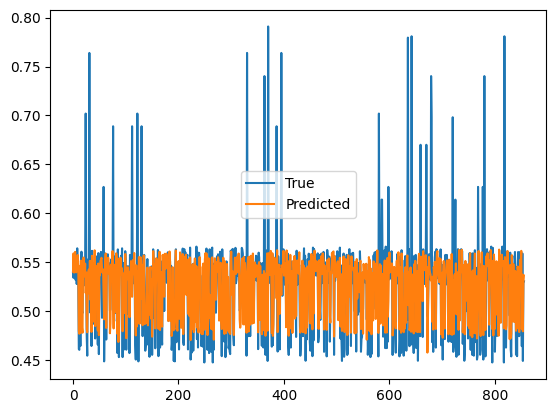

Mean Absolute Error:  0.02031613625237875


In [171]:
# Load the best model
model.load_state_dict(torch.load('model_15.pth'))

# Select dataloader
dataloader = train_loader

# Run predictions on the training set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for data, target in tqdm(dataloader, desc='Testing'):
        data = data.permute(0,3,1,2).float().to(device)
        target = target.float().to(device)
        outputs = model(data)
        y_pred.extend(outputs.tolist())
        y_true.extend(target.tolist())

# Plot the predictions
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))


## Visualization with OpenCV

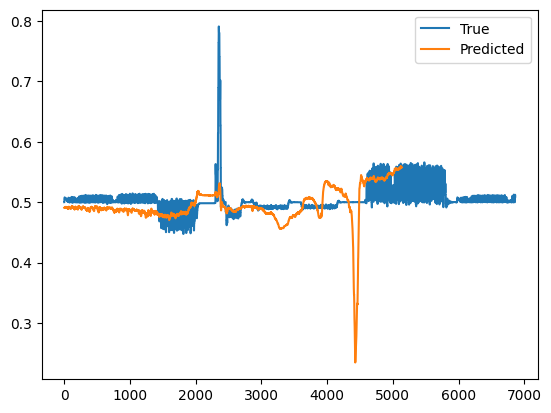

ValueError: Found input variables with inconsistent numbers of samples: [6861, 5134]

In [174]:
# Load model 
model.load_state_dict(torch.load('model_15.pth'))

# Choose what images to use for inference
inference_imgs =  images #filt_images # images
inference_labels = labels_norm #filt_labels #labels_norm 

y_pred = []

# Loop over the filtered images and show them using cv2.imshow with the respective steering angle in the window
for i in range(len(inference_imgs)):
    img = cv2.imread('data/images/' + inference_imgs[i])


    # Preprocess the image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = torch.Tensor(image).permute(2,0,1).unsqueeze(0).to(device)

    # Run the model
    output = model(image)
    output = output.item()
    y_pred.append(output)

    # Wrote the predicted steering angle in the image
    output_str = f"Predicted Steering Angle: {output:.2f}"
    cv2.putText(img, output_str, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Wrote the real steering angle in the image
    label_norm = inference_labels[i]
    label_str = f"Steering Angle: {label_norm:.2f}"
    cv2.putText(img, label_str, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw steering wheel to visualize
    wheel_angle = output * 180
    center = (int(img.shape[1]/2), int(img.shape[0]/2))
    cv2.circle(img, center, 50, (0,0,255), 2)
    angle = np.deg2rad(wheel_angle)
    x = int(center[0] + 50*np.cos(angle))
    y = int(center[1] + 50*np.sin(angle))
    cv2.line(img, center, (x,y), (0,0,255), 2)

    # Draw to bars to visualize respect to the real steering angle
    bar_height = int(output * 200)
    cv2.rectangle(img, (10, 200), (30, 400), (0,0,255), 2)
    cv2.rectangle(img, (10, 400-bar_height), (30, 400), (0,0,255), -1)
    bar_height = int(label_norm * 200)
    cv2.rectangle(img, (40, 200), (60, 400), (0,255,0), 2)
    cv2.rectangle(img, (40, 400-bar_height), (60, 400), (0,255,0), -1)

    cv2.imshow('Image', img)
    if cv2.waitKey(0) == ord('q'):
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

# Plot the predictions
plt.plot(inference_labels, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(inference_labels, y_pred))
